In [1]:
import torch
import torch.nn as nn

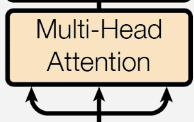

The Self Attention block
- Takes the embedding size `256` and the number of heads `8`
- The number of heads will say the embedding dimension should be divided into how many heads

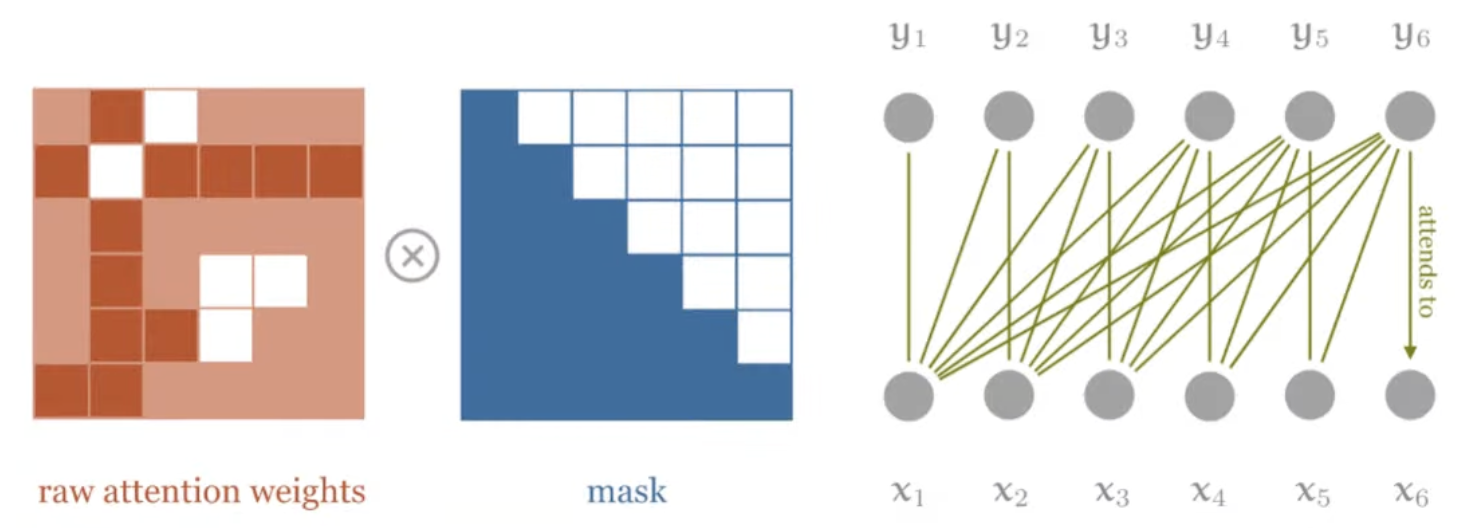

- Mask for the Target is going to be a Triangular Matrix

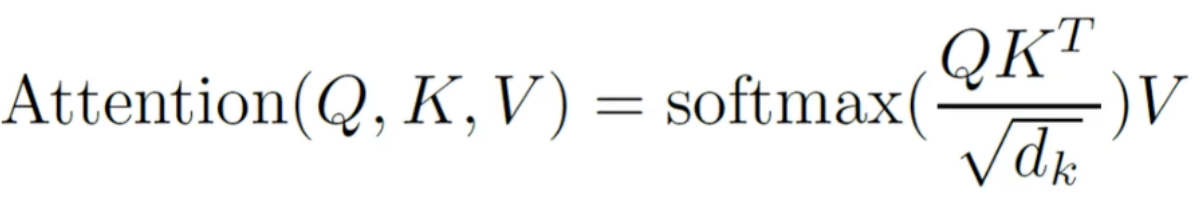

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        print("**************** INITIALIZING THE SELF ATTENTION ****************")
        super(SelfAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads # 256//8 = 32

        assert (self.head_dim * heads == embed_size), "Embedding Size should be divisible by number of heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False) #32, 32
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False) #32, 32
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False) #32, 32
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size) # (8*32) 256, 256
    
    def forward(self, values, keys, query, mask):
        print("******************* Step-5.1 : The Self Attention Block ********************** ")
        N = query.shape[0] # Batch Size. That is gonna be how many examples we gonna send at the same time.
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1] #This is just the sequence length of the text

        # Split embedding into self.head pieces
        '''
        The (self.heads, self.head_dim) was in single dimension like this (1, 256).
        Now it will be reshaped to (8, 32) -> 8 is the number of heads and 32 is the dimension of each head
        '''
        #Batch Size, Sequence Length, Number Of Heads(8), Head Dimension (32)
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        print("******************* Step-5.1 : The Rehsaped values is ********************** ", values.shape)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        print("******************* Step-5.1 : The Rehsaped keys is ********************** ", keys.shape)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)
        print("******************* Step-5.1 : The Rehsaped queries is ********************** ", queries.shape)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        '''
            - queries_shape: (N, queryLength, heads, head_dim)
            - keys_shape: (N, keyLength, heads, head_dim)
            - energry_shape: (N, heads, query_len, key_len)
        
        #query_len is the Target Sentence
        #key_len is the Source Sentence
        For each word in the Target, how much we are gonna pay attention to the Input (The Source Sentence)
        '''

        energy = torch.einsum("nqhd, nkhd -> nhqk", [queries, keys])
        print("******************* Step-5.1 : The Energy Shape is ********************** ", energy.shape)
        if mask is not None:
            '''
            If the mask element is 0, it means that we have to shut that off. To do that, we are setting (-infinity)
            '''
            energy = energy.masked_fill(mask==0, float("-1e20"))
        
        #When a Softmax is run, the negaitve infinity will ultimately turn to Zero
        attention = torch.softmax(energy/(self.embed_size**(1/2)), dim=3)
        print("******************* Step-5.1 : The Attention Shape is ********************** ", attention.shape)

        '''
        - dim=3 means that we are normalizing across the `key_len`.
        - Essentially the attention score is Normalized to 1 across the Source Sentence
        - If the `first` for example is 0.8 that means we are paying 80% attention to the first word in the Source Sentence
        '''

        out = torch.einsum("nhql,nlhd -> nqhd", [attention, values]).reshape(
            N, query_len, self.heads*self.head_dim
        ) #The Reshape is done for the concatenation

        # attention_shape: (N, heads, query_len, key_len)
        # value_shape: (N, value_len, heads, head_dim)
        # Aftern einsum out_shape: (N, query_len, heads, head_dim), then flatten the last two dimension
        # The key_len and value_len are going to be the same in the Encoder. We are gonna multiply across that dimension

        print("******************* Step-5.1 : The Out Shape is ********************** ", out.shape)
        out = self.fc_out(out)
        print("******************* Step-5.1 : The Out Shape AfterFC is ********************** ", out.shape)
        return out

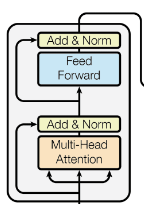

Sequentially, 

- The attentions is calculated
- The attention is sent to the Add and Normalize layer
- The result of the Normalization is sent to the Feed Forward layer
- The feed forward results are sent to the Add and Normalize layer

The Layer Normalization, normalizes across the example (averaging the neurons) #FIXME revisit this


In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        print("**************** INITIALIZING THE TRANSFORMER BLOCK ****************")
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size=embed_size, heads=heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion*embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion*embed_size, embed_size)
        ) #The two different linear layers are just written to add extra computation. Not gonna add anything new
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        print("******************* Step-4.1 : The value shape is ********************** ", value.shape)
        print("******************* Step-4.1 : The key shape is ********************** ", key.shape)
        print("******************* Step-4.1 : The query shape is ********************** ", query.shape)
        print("******************* Step-4.1 : The mask is ********************** ", mask)
        print("******************* Step-4.1 : The mask shape is ********************** ", mask.shape)

        print()
        print("******************* Step-4.1 : Calling the Self Attention Block ********************** ")
        attention = self.attention(value, key, query, mask)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))

        return out

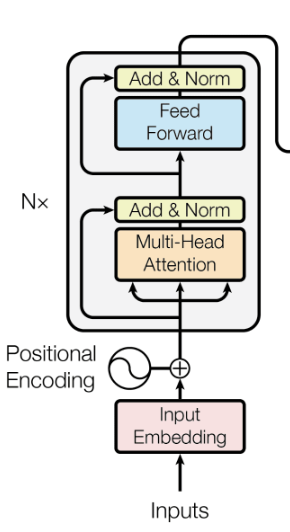

In [4]:
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length):
        print("**************** INITIALIZING THE ENCODER ****************")
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion
                ) for _ in range(num_layers)
            ]
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask): #x is the input
        print("******************* Step-3.1 : Encoder Forward Method*******************")
        print("******************* Step-3.1 : The Value of x is ********************** ", x)
        print("******************* Step-3.1 : The Shape of x is ********************** ", x.shape)

        N, seq_length = x.shape
        print("******************* Step-3.1 : The N value - Batch Size is ********************** ", N)
        print("******************* Step-3.1 : The Total Length of the Input Sentence is ********************** ", seq_length)

        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        print("******************* Step-3.1 : The Positions is ********************** ", positions)
        print("******************* Step-3.1 : The Positions Shape is ********************** ", positions.shape)

        word_embedding_result = self.word_embedding(x)
        print("******************* Step-3.1 : The Word Embedding result Shape is ********************** ", word_embedding_result.shape)

        position_embedding_result = self.position_embedding(positions)
        print("******************* Step-3.1 : The Position Embedding result Shape is ********************** ", position_embedding_result.shape)

        out = self.word_embedding(x) + self.position_embedding(positions)
        print("******************* Step-3.1 : The Output Embedding result Shape is ********************** ", out.shape)

        layerCounter = 1
        for layer in self.layers:
            print("******************* Step-3.1 : Processing Layer Number ********************** ", layerCounter)
            out = layer(out, out, out, mask) #The Key, Value and Query are gonna be the same
            layerCounter += 1
        
        return out


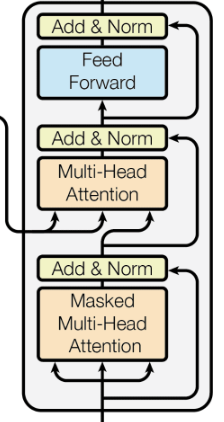

Sequentially, 

- The attention mechanism is called
- Normalization is done on the attention
- Then sent to the Transformers block

In [5]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        print("**************** INITIALIZING THE DECODER BLOCK ****************")
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    '''
    - The x -> Input from the Target.
    - value, key -> from the Encoders
    - src_mask -> The padding. to avoid computation on the padded characters
    '''
    def forward(self, x, value, key, src_mask, trg_mask):
        # x -> will be sent 3 times to the Attention block as value, key, query
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)

        return out

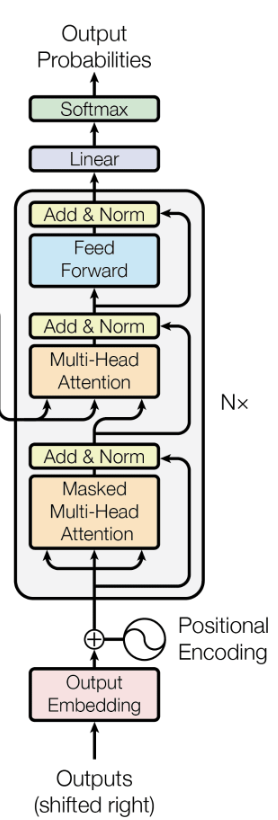

In [6]:
class Decoder(nn.Module):
    def __init__(self, trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, device, max_length):
        print("**************** INITIALIZING THE DECODER ****************")
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [DecoderBlock(embed_size, heads, forward_expansion, dropout, device) for _ in range(num_layers)]
        )

        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)
        
        out = self.fc_out(x)
        return out

In [7]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, embed_size=256, 
                 num_layers=6, forward_expansion=4, heads=8, dropout=0, device="cpu", max_length=100):
        print("**************** INITIALIZING THE TRANSFORMER ****************")
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, embed_size, num_layers, heads, device, forward_expansion,
                                dropout, max_length)
        self.decoder = Decoder(trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, 
                               device, max_length)
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    
    def make_src_mask(self, src):
        print("Making the Source Mask....")
        print("The Source is : ", src)
        print("The Source Shape is : ", src.shape)
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        print("The Source Mask is : ", src_mask)
        print("The Source Mask Shape is : ", src_mask.shape)
        print("-------------------------------------------------------")
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        print("Making the Target Mask...")
        print("The Target is : ", trg)
        print("The Target Shape is : ", trg.shape)
        N, trg_len = trg.shape
        print("The N value is : ", N)
        print("The Target Length is : ", trg_len)
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )
        print("The Target Mask is : ", trg_mask)
        print("The Target Mask Shape is : ", trg_mask.shape)
        print("-------------------------------------------------------")
        return trg_mask.to(self.device)
    
    def forward(self, src, trg):
        print("******************* Step-1 : The Source data is Masked *******************")
        src_mask = self.make_src_mask(src)
        print("******************* Step-2 : The Target data is Masked *******************")
        trg_mask = self.make_trg_mask(trg)
        print("******************* Step-3 : Encoder is run to Encode the Source data *******************")
        enc_src = self.encoder(src, src_mask)
        # out = self.decoder(trg, enc_src, src_mask, trg_mask)
        out = None
        return out

In [8]:
device = "cpu"

x = torch.tensor([[1,5,6,4,3,9,5,2,0]]).to(device)
trg = torch.tensor([[1,7,4,3,5,9,2,0]]).to(device)

In [9]:
x.shape, trg.shape

(torch.Size([1, 9]), torch.Size([1, 8]))

In [10]:
src_pad_idx = 0
trg_pad_idx = 0
src_vocab_size = 10
trg_vocab_size = 10

In [11]:
model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx).to(device)

**************** INITIALIZING THE TRANSFORMER ****************
**************** INITIALIZING THE ENCODER ****************
**************** INITIALIZING THE TRANSFORMER BLOCK ****************
**************** INITIALIZING THE SELF ATTENTION ****************
**************** INITIALIZING THE TRANSFORMER BLOCK ****************
**************** INITIALIZING THE SELF ATTENTION ****************
**************** INITIALIZING THE TRANSFORMER BLOCK ****************
**************** INITIALIZING THE SELF ATTENTION ****************
**************** INITIALIZING THE TRANSFORMER BLOCK ****************
**************** INITIALIZING THE SELF ATTENTION ****************
**************** INITIALIZING THE TRANSFORMER BLOCK ****************
**************** INITIALIZING THE SELF ATTENTION ****************
**************** INITIALIZING THE TRANSFORMER BLOCK ****************
**************** INITIALIZING THE SELF ATTENTION ****************
**************** INITIALIZING THE DECODER ****************
*********

In [12]:
out = model(x, trg[:, :-1])

******************* Step-1 : The Source data is Masked *******************
Making the Source Mask....
The Source is :  tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0]])
The Source Shape is :  torch.Size([1, 9])
The Source Mask is :  tensor([[[[ True,  True,  True,  True,  True,  True,  True,  True, False]]]])
The Source Mask Shape is :  torch.Size([1, 1, 1, 9])
-------------------------------------------------------
******************* Step-2 : The Target data is Masked *******************
Making the Target Mask...
The Target is :  tensor([[1, 7, 4, 3, 5, 9, 2]])
The Target Shape is :  torch.Size([1, 7])
The N value is :  1
The Target Length is :  7
The Target Mask is :  tensor([[[[1., 0., 0., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0., 0., 0.],
          [1., 1., 1., 0., 0., 0., 0.],
          [1., 1., 1., 1., 0., 0., 0.],
          [1., 1., 1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 1., 1.]]]])
The Target Mask Shape is :  torch.Size([1, 1, 7, 

In [13]:
# out.shape